# Sentiment Analysis on Healthcare Company Reviews: NLP Project


------

**Objective**: Build a sentiment analysis classifier for healthcare feedback (e.g., patient reviews) using scikit-learn and NLTK, predicting positive/negative sentiment. Demonstrates NLP preprocessing, ML modeling, and MLOps for production-ready analytics.

**Relevance**: Aligns with a focus on unstructured data analytics for healthcare, showcasing skills in NLP, ML, and MLOps.

**Author**: John Ryan | GitHub: https://github.com/JJRyan0/jjryan0

**Skills**: NLP (NLTK, spaCy), scikit-learn, MLflow, Python, Healthcare Analytics


This notebook showcases a complete **Natural Language Processing (NLP)** pipeline for classifying the sentiment of company reviews. From raw unstructured text to meaningful insights, we walk through each phase of the process, including data cleaning, feature extraction, model training, and evaluation.

## Objectives
- Clean and preprocess review text data
- Tokenize, remove stopwords, and normalize text
- Convert text into numerical form using **TF-IDF vectorization**
- Train a **Logistic Regression** model to classify sentiment
- Evaluate model performance using precision, recall, and F1-score

---

## Process Flow

```mermaid
graph TD
    A[Raw Review Data] --> B[Text Preprocessing]
    B --> C[Tokenization & Stopword Removal]
    C --> D[TF-IDF Vectorization]
    D --> E[Train/Test Split]
    E --> F[Logistic Regression Model]
    F --> G[Model Evaluation]
    G --> H[Insights & Reporting]


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import nltk
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn

# Download NLTK resources
#nltk.download('stopwords')
#nltk.download('wordnet')

# Load spaCy English model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#dont forget pip install nltk !


/Users/johnryan/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Data Preparation
Import a a real dataset (Kaggle healthcare reviews) for portfolio enhancement.

In [3]:
#from ibm_watson import NaturalLanguageUnderstandingV1
#from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
#authenticator = IAMAuthenticator('YOUR_API_KEY')
#nlu = NaturalLanguageUnderstandingV1(version='2022-04-07', authenticator=authenticator)

In [5]:
# Synthetic healthcare feedback dataset
data = pd.read_csv('/Users/johnryan/Downloads/Documents/Data Sets/reviews.csv')

# Display dataset
print('Dataset Preview:')
print(data.head())

# Check class balance
print('\nClass Distribution:')
print(data['CompanyName'].value_counts())

Dataset Preview:
       CompanyName                                             Review  \
0  united_american  United American has been fantastic. We have ha...   
1  united_american  We've had very good luck with United American....   
2  united_american  We've had a United American Insurance policy f...   
3  united_american  We were with Cleveland Clinic and when they st...   
4  united_american  My husband worked for a bank and we had a life...   

         Date OwnershipType  
0   4/22/2023        Public  
1  10/28/2022        Public  
2  10/12/2022        Public  
3    9/1/2022        Public  
4   5/30/2022        Public  

Class Distribution:
CompanyName
united_health_care      2094
humana                  1798
kaiser                  1259
cigna_health            1167
aetna_health            1117
bluecross                949
anthem                   613
wellcare                 443
health_net               420
united_american          388
aarp_health              130
amerihealth 

## 2. Text Preprocessing

Clean and preprocess feedback text using NLTK and spaCy for tokenization, stopword removal, and lemmatization.

* __WordNetLemmatizer()__ is a natural language processing (NLP) method to reduce words to their base or dictionary form — called a lemma. Lemmatization is the process of reducing a word to its canonical form based on its meaning and part of speech. for example: "better" = "good". If you don’t provide the pos (part of speech) inside the WordNetLemmatizer(), it defaults to noun, which may not always yield the correct lemma.

* __word_tokenize(text.lower())__ this section takes the text and converts it to lowercase, and splits it into individual token( words and punctuations). Chunks the text into a list of separate individual words for example ['We', 'were', 'with', 'Cleveland', 'Clinic'].

* __Stopwords__ are common words in a language that are often filtered out in natural language processing (NLP) tasks because they carry little meaningful information.

    for example: {'a','about','above', 'after','again', 'against',..}
 
---

Step 1: load a list of common English stopwords and store them in a set for fast lookup.

Step 2: Create an instance of the WordNetLemmatizer

Step 3: Create function to preprocees the text and return the tokened words/punctuations as output.

Step 4: Apply and map review processed data to the dataframe as new column 'processed_feedback'

In [7]:

#load a list of common English stopwords and store them in a set for fast lookup.
stop_words = set(stopwords.words('english'))
#creates an instance of the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Define preprocessing function:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    tokens = word_tokenize(text.lower())
    #filters out non-aplabetic chars & removed stopwords
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return ' '.join(tokens) #convert a list of tokens back into a single string, where each token is separated by a space.
#apply and map review processed data to the dataframe as new column 'processed_feedback'
data['processed_feedback'] = data['Review'].apply(preprocess_text)

In [8]:
data.head(2)

,CompanyName,Review,Date,OwnershipType,processed_feedback
0,united_american,United American has been fantastic. We have ha...,4/22/2023,Public,united american fantastic one bit trouble coll...
1,united_american,We've had very good luck with United American....,10/28/2022,Public,good luck united american got used husband ope...


## 3. Feature Extraction - Rule-Based Filtering

Goal: Convert text to numerical features using TF-IDF vectorization, incorporating dimensionality reduction via max_features.Used in sentiment analysis tasks for product reviews, social media feedback, customer feedback.

* __Polarity:__ Gives the polarity score of the text, which is a float between -1.0 and 1.0:

    -1.0 → Very negative, 0.0 → Neutral, +1.0 → Very positive

* __TF-IDF vectorization:__ Used to convert a collection of text documents into a matrix of TF-IDF features. Gives more weight to words that are frequent in a document but rare across documents.

    __Term Frequency (TF):__ How frequently a term appears in a document.

    __Inverse Document Frequency (IDF):__ How unique or rare the term is across all documents.

---



Step 1: Function to create mapped sentiments based on the polarity scores of the preprosessed text.

Step 2: Convert text to numerical features using TF-IDF vectorization.

Step 3: Map the numerical features to a class {'positive': 1, 'negative': 0}

Step 4: Create train set and test sets for ML Model  


In [9]:
from textblob import TextBlob
#function created to map sentiments based on the preprosessed text, assign polarities as classes
def get_sentiment(text):
    try:
        polarity = TextBlob(text).sentiment.polarity
        if polarity > 0:
            return 'positive'
        elif polarity < 0:
            return 'negative'
        else:
            return 'neutral'
    except:
        return 'neutral'

data['Sentiment'] = data['Review'].apply(get_sentiment)
data = data[data['Sentiment'] != 'neutral']  # Optional: drop neutral if you're doing binary classification


#Convert text to numerical features using TF-IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(data['processed_feedback']).toarray()
y = data['Sentiment'].map({'positive': 1, 'negative': 0})

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
print(y.isnull().sum())

0


## 4. Customer Sentiment - Model Training - Logistic Regression

Train a Logistic Regression model for sentiment classification, logging with MLflow for MLOps.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)

print('Model Accuracy:', accuracy)
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Model Accuracy: 0.7658349328214972

Classification Report:
              precision    recall  f1-score   support

    Negative       0.77      0.66      0.71       921
    Positive       0.76      0.85      0.80      1163

    accuracy                           0.77      2084
   macro avg       0.77      0.76      0.76      2084
weighted avg       0.77      0.77      0.76      2084



## Results
---

__76.6%__ is a solid baseline for a first pass at sentiment classification using logistic regression and TF-IDF.

We see a __Positive sentiment detection is strong:__ High recall (0.85) means the model is catching most of the true positives.

We see a Negative sentiment detection is weaker: Lower recall (0.66) suggests that some negative reviews are being misclassified as positive.

## 5. Confusion Matrix - Visualization
Visualize the confusion matrix to evaluate model performance.

__True Positives (TP):__ 984.  Reviews that are actually positive, the model correctly predicted 984 of them

__True Negatives (TN):__ 612.  The reviews that are actually identified negative, the model correctly predicted 612 of them as negative.

__False Positives (FP):__ 309. The model made 309 mistakes by labeling negative reviews as positive! __Need to start Increasing the F1 threshold to see if this helps increase precision reducing False Positives, we want to monitor how the model process mistakes for negative reviews.

__False Negatives (FN):__ 179. - Positive reviews incorrectly predicted as negative i.e a Type II error.

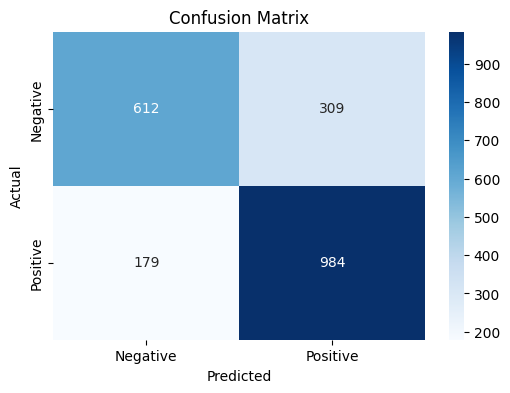

In [8]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')  # Save for portfolio
plt.show()

## 6. Example Prediction
Test the model on new feedback to demonstrate real-world application.

In [9]:
# New feedback
new_feedback = ['The doctor was attentive and kind, great visit!']
new_processed = [preprocess_text(text) for text in new_feedback]
new_X = tfidf.transform(new_processed).toarray()
prediction = model.predict(new_X)

print('New Feedback:', new_feedback[0])
print('Predicted Sentiment:', 'Positive' if prediction[0] == 1 else 'Negative')

New Feedback: The doctor was attentive and kind, great visit!
Predicted Sentiment: Positive


## 7. Next Steps for Enhancement
- **Real Dataset**: Use a larger healthcare dataset.
- **Advanced Models**: Experiment with BERT or IBM Watson NLP for improved accuracy.
- **Azure Integration**: Deploy model in Azure ML, leveraging Azure Data Factory for orchestration.
